## **Phishing URL Dataset: Exploratory Data Analysis (EDA)**

### **Loads essential libraries for data manipulation, file handling, and visualization.**

In [1]:
import os, textwrap, re
import typing as t
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### **Set working directory to root**

In [2]:
%pwd
os.chdir("../")
%pwd



'd:\\MLops\\NetworkSecurity'

### **1- Load the data**

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
DATA_FILE = Path("data/raw/PhiUSIIL_Phishing_URL_Dataset.csv") 
assert DATA_FILE.exists(), f"Missing dataset at {DATA_FILE}"

# Robust CSV load (utf-8 first, permissive fallback)
try:
    df = pd.read_csv(DATA_FILE)
    print("Data loaded succesfully!")
except UnicodeDecodeError:
    df = pd.read_csv(DATA_FILE, encoding_errors="ignore")


Data loaded succesfully!


- Confirm Expected Columns Exist, validates the presence of the URL column and auto-detects the target label column.

In [5]:
# Confirm expected columns exist
assert "URL" in df.columns, "Expected a URL column"
label_col = next((c for c in df.columns if c.lower() in {"label","result","y","target"}), None)
assert label_col is not None, "No obvious label column found"
print(f"Detected label column: {label_col}")

Detected label column: label


- Analyzes label distribution, ensures binary classification, and creates a standardized target column.

In [6]:
# Confirm mapping: 1=legit, 0=phish (we'll keep raw, and add canonical y)
vc = df[label_col].value_counts(dropna=False).to_dict()
print("Label value counts:", vc)
unique_labels = set(df[label_col].unique())
assert unique_labels <= {0,1}, f"Unexpected labels present: {unique_labels}"
df["y"] = df[label_col].astype(int)  # 1=legit, 0=phish

Label value counts: {1: 134850, 0: 100945}


- Checks for missing values and duplicate URLs to assess data quality.

In [ ]:
# Basic nulls & duplicates 
nulls = df.isna().sum().sort_values(ascending=False)
dup_url_count = df["URL"].duplicated(keep=False).sum()
print(f"Shape: {df.shape} | Duplicate URL rows: {dup_url_count}")
print("\nTop nulls (if any):\n", nulls.head(10))

Shape: (235795, 56) | Duplicate URL rows: 850

Top nulls (if any):
 URL                   0
URLLength             0
URLTitleMatchScore    0
HasFavicon            0
Robots                0
IsResponsive          0
NoOfURLRedirect       0
NoOfSelfRedirect      0
HasDescription        0
NoOfPopup             0
dtype: int64


### **2- URL Morphology Functions**
- Applies the custom functions to create new features from the URL column, displays the first 5 rows for inspection, and generates a statistical summary including percentiles to understand feature distributions and their relationship to the target variable.

In [8]:
def url_length(s: t.Union[str, t.Any]) -> int:
    """Calculate URL length, handling non-string inputs."""
    try:
        return len(s) if isinstance(s, str) else 0
    except (TypeError, AttributeError):
        return 0

In [9]:
def digit_ratio(s: t.Union[str, t.Any]) -> float:
    """Calculate digit ratio in URL, handling edge cases."""
    try:
        if not isinstance(s, str) or not s:
            return 0.0
        digits = sum(1 for ch in s if ch.isdigit())
        return digits / len(s)
    except (TypeError, AttributeError, ZeroDivisionError):
        return 0.0

In [10]:
def subdomain_count(s: t.Union[str, t.Any]) -> int:
    """Count subdomains in URL host, with error handling."""
    try:
        if not isinstance(s, str) or not s:
            return 0
        # Extract host part
        host = s.split("://", 1)[-1].split("/", 1)[0]
        return max(0, host.count(".") - 1)
    except (AttributeError, IndexError):
        return 0

In [11]:
df["url_len"] = df["URL"].map(url_length)
df["url_digit_ratio"] = df["URL"].map(digit_ratio)
df["url_subdomains"] = df["URL"].map(subdomain_count)

display(df.head(5))
print(
    "Morphology summary:\n",
    df[["url_len","url_digit_ratio","url_subdomains","y"]]
      .describe(percentiles=[0.5,0.9,0.99])
)


,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label,y,url_len,url_digit_ratio,url_subdomains
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,0.061933,3,1,0,0,0.0,18,0.581,0,0.0,0,0,0,1,0.032,1,558,9381,1,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µ...,0.000000,0.000000,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,34,20,28,119,0,124,1,1,32,0.0,1
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,0.050207,2,1,0,0,0.0,9,0.391,0,0.0,0,0,0,2,0.087,1,618,9381,1,johannes gutenberg-universitÃ¤t mainz,55.555556,55.555556,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,50,9,8,39,0,217,1,1,24,0.0,1
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,0.064129,2,2,0,0,0.0,15,0.517,0,0.0,0,0,0,2,0.069,1,467,682,1,voice fm southampton,46.666667,46.666667,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,10,2,7,42,2,5,1,1,30,0.0,2
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,0.057606,3,1,0,0,0.0,13,0.500,0,0.0,0,0,0,1,0.038,1,6356,26824,1,home page: seminars in fetal and neonatal medi...,0.000000,0.000000,0,1,1,0,0,0,1,12,0,1,1,1,0,0,1,1,1,3,27,15,22,1,31,1,1,27,0.0,1
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,0.059441,3,1,0,0,0.0,20,0.606,0,0.0,0,0,0,1,0.030,1,6089,28404,1,fundaciÃ³n rewilding argentina,100.000000,100.000000,0,1,1,1,1,1,0,2,0,1,1,1,0,1,1,0,1,244,15,34,72,1,85,1,1,34,0.0,1


Morphology summary:
              url_len  url_digit_ratio  url_subdomains              y
count  235795.000000    235795.000000   235795.000000  235795.000000
mean       35.366954         0.028385        1.164770       0.571895
std        41.214346         0.070279        0.600976       0.494805
min        14.000000         0.000000        0.000000       0.000000
50%        28.000000         0.000000        1.000000       1.000000
90%        50.000000         0.111111        2.000000       1.000000
99%       144.000000         0.339286        3.000000       1.000000
max      6097.000000         0.684211       10.000000       1.000000


## **Class balance and first slices**

In [12]:
# Class balance
counts = df["y"].value_counts().rename({1:"legit", 0:"phish"})
balance = (counts / counts.sum()).round(4)
print("Class counts:\n", counts)
print("Class proportions:\n", balance)

Class counts:
 y
legit    134850
phish    100945
Name: count, dtype: int64
Class proportions:
 y
legit    0.5719
phish    0.4281
Name: count, dtype: float64


- Discretizes continuous features into bins for analysis, then uses cross-tabulations to examine how each bin correlates with phishing probability. The normalize="index" computes row-wise percentages, revealing patterns like longer URLs being more likely phishing. Bins are custom-defined to capture meaningful ranges, and results are printed as percentages for interpretability.

In [13]:
# URL length bins and digit-ratio bins
len_bins = pd.cut(df["url_len"], bins=[0,50,100,150,200,500,1_000,10_000], right=False)
dig_bins = pd.cut(df["url_digit_ratio"], bins=[0,0.05,0.1,0.2,0.3,1.0], right=False)

len_slice = pd.crosstab(len_bins, df["y"], normalize="index").rename(columns={1:"legit",0:"phish"})
dig_slice = pd.crosstab(dig_bins, df["y"], normalize="index").rename(columns={1:"legit",0:"phish"})

print("\nURL length slice (row %):\n", (len_slice*100).round(1))
print("\nDigit ratio slice (row %):\n", (dig_slice*100).round(1))


URL length slice (row %):
 y              phish  legit
url_len                    
[0, 50)         36.3   63.7
[50, 100)       99.8    0.2
[100, 150)     100.0    0.0
[150, 200)     100.0    0.0
[200, 500)     100.0    0.0
[500, 1000)    100.0    0.0
[1000, 10000)  100.0    0.0

Digit ratio slice (row %):
 y                phish  legit
url_digit_ratio              
[0.0, 0.05)       31.9   68.1
[0.05, 0.1)       91.6    8.4
[0.1, 0.2)        94.5    5.5
[0.2, 0.3)        99.5    0.5
[0.3, 1.0)        99.9    0.1


- Conditionally analyzes the top 20 most frequent TLDs (Top-Level Domain) if a TLD column exists, filtering the dataset to these common domains to avoid noise from rare ones. It creates a cross-tabulation normalized by rows to show phishing percentages per TLD, sorted by descending phishing risk. This helps identify high-risk domains like '.top' or '.dev' that may require special attention in modeling. If no TLD column is found, it suggests future derivation using URL parsing libraries.

In [14]:
# Top TLD slice if column exists
tld_col = next((c for c in df.columns if c.lower()=="tld"), None)
if tld_col:
    top_tlds = df[tld_col].value_counts().head(20).index
    tld_slice = (
        pd.crosstab(df.loc[df[tld_col].isin(top_tlds), tld_col], df["y"], normalize="index")
          .rename(columns={1:"legit",0:"phish"})
          .sort_values("phish", ascending=False)
    )
    print("\nTop-20 TLD slice (row %):\n", (tld_slice*100).round(1))
else:
    print("\nNo TLD column present (or named differently); we can derive it later if needed.")


Top-20 TLD slice (row %):
 y     phish  legit
TLD               
top    99.9    0.1
dev    98.6    1.4
app    97.8    2.2
co     91.6    8.4
io     89.7   10.3
ru     77.0   23.0
info   57.0   43.0
net    43.7   56.3
com    38.9   61.1
br     35.4   64.6
fr     26.5   73.5
de     17.2   82.8
au     12.5   87.5
org    12.1   87.9
it     11.6   88.4
nl     11.1   88.9
ca      6.9   93.1
jp      6.2   93.8
uk      5.0   95.0
edu     0.3   99.7


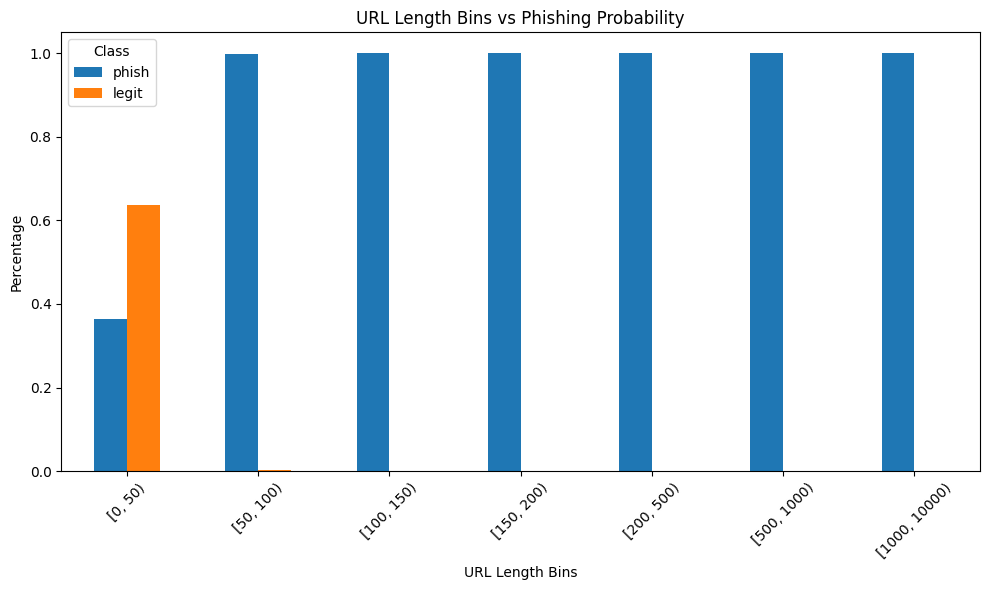

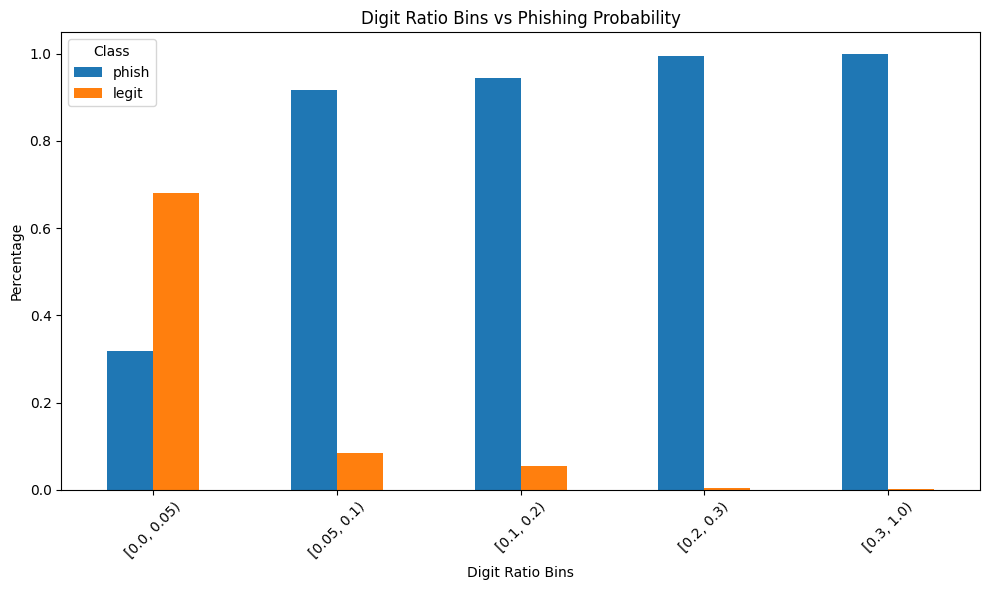

In [15]:
# Bar plot for URL length slices
len_slice.plot(kind='bar', figsize=(10, 6), title='URL Length Bins vs Phishing Probability')
plt.ylabel('Percentage')
plt.xlabel('URL Length Bins')
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

# Bar plot for digit ratio slices
dig_slice.plot(kind='bar', figsize=(10, 6), title='Digit Ratio Bins vs Phishing Probability')
plt.ylabel('Percentage')
plt.xlabel('Digit Ratio Bins')
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.tight_layout()

-This function identifies columns with ≤4 unique values, prints their names, and for each, lists the unique values with counts using value_counts(). It also highlights binary columns separately. Add this as a new cell in your notebook.

In [20]:
def create_low_unique_df(df, max_unique=4):
    """
    Creates a DataFrame for columns with low unique values (≤ max_unique).
    Rows: column names, Columns: unique values, Values: counts.
    """
    low_unique_cols = df.nunique()[df.nunique() <= max_unique].index.tolist()
    if not low_unique_cols:
        print("No columns with ≤10 unique values found.")
        return
    
    # Collect data for DataFrame
    data = {}
    for col in low_unique_cols:
        value_counts = df[col].value_counts(dropna=False).to_dict()
        data[col] = value_counts
    
    # Create DataFrame
    result_df = pd.DataFrame(data).T.fillna(0).astype(int)
    print("Low Unique Columns DataFrame:")
    display(result_df)
    return result_df

# Usage
low_unique_df = create_low_unique_df(df)

Low Unique Columns DataFrame:


,0,1
IsDomainIP,235157,638
HasObfuscation,235310,485
IsHTTPS,51256,184539
HasTitle,32714,203081
HasFavicon,150492,85303
Robots,172946,62849
IsResponsive,88538,147257
NoOfURLRedirect,204331,31464
NoOfSelfRedirect,226338,9457
HasDescription,132002,103793
